In [2]:
import json
from dataclasses import asdict, is_dataclass
from pathlib import Path
import sys
import pandas as pd

# Base path for data
BASE = Path.cwd()

# Load datasets
pool_cfg = pd.read_csv(BASE / 'dune_pipeline' / 'pool_config_eth_usdt_0p3.csv')
slot0 = pd.read_csv(BASE / 'dune_pipeline' / 'slot0_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv')
swaps = pd.read_csv(BASE / 'dune_pipeline' / 'swaps_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv')
mints = pd.read_csv(BASE / 'dune_pipeline' / 'mints_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv')
burns = pd.read_csv(BASE / 'dune_pipeline' / 'burns_2025_09_01_to_2025_10_01_eth_usdt_0p3.csv')
tokens = pd.read_csv(BASE / 'dune_pipeline' / 'token_metadata_eth_usdt_0p3.csv')
ethusdt = pd.read_csv(BASE / 'research' / 'simulation_2' / 'ETHUSDT_hourly_data_20241101_20251101.csv')

# Import the simulator
sys.path.append(str(BASE / 'research' / 'simulation_3'))
from fee_simulator import UniswapV3FeeSimulator

sim = UniswapV3FeeSimulator(
    pool_cfg=pool_cfg,
    tokens=tokens,
    slot0=slot0,
    swaps=swaps,
    mints=mints,
    burns=burns,
    eth_usdt_prices=ethusdt,
)

# Parameters (edit here)
PRICE_LOWER = 4200.0
PRICE_UPPER = 4400.0
T_START_ISO = '2025-09-01T00:00:00Z'
T_END_ISO = '2025-09-13T06:00:00Z'

result = sim.simulate(
    price_lower=PRICE_LOWER,
    price_upper=PRICE_UPPER,
    start=T_START_ISO,
    end=T_END_ISO,
    total_usd=1000,
    validate=False,
    use_swap_liquidity=True,
    accounting_mode='direct',
    protocol_fee_encoding='base256',
)

# Normalize to dict for downstream convenience
res_dict = result.to_dict() if hasattr(result, 'to_dict') else (asdict(result) if is_dataclass(result) else result)
print(json.dumps(res_dict, indent=2))


{
  "pool": "0x4e68ccd3e89f51c3074ca5072bbac773960dfa36",
  "fee_bps": 3000,
  "tokens": {
    "token0": {
      "address": "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2",
      "symbol": "WETH",
      "decimals": 18
    },
    "token1": {
      "address": "0xdac17f958d2ee523a2206206994597c13d831ec7",
      "symbol": "USDT",
      "decimals": 6
    }
  },
  "window_utc": {
    "start": "2025-09-01T00:00:00+00:00",
    "end": "2025-09-13T06:00:00+00:00"
  },
  "position_ticks": {
    "lower": -192900,
    "upper": -192420
  },
  "price": {
    "start": 4385.383153638338,
    "end": 4732.581420687239
  },
  "start_tokens": {
    "token0_amount": 0.016462107631523237,
    "token1_amount": 927.807351,
    "token0_usd": 72.37549158091561,
    "token1_usd": 927.807351,
    "total_usd": 1000.1828425809157
  },
  "start_principal_tokens": {
    "token0_amount": 0.016462107631523237,
    "token1_amount": 927.80735,
    "token0_usd": 72.3754915809156,
    "token1_usd": 927.80735,
    "total_usd": 

In [3]:
import pandas as pd
from IPython.display import display

# Destructure and present concise tables
pool = res_dict['pool']
fee_bps = res_dict['fee_bps']
sym0 = res_dict['tokens']['token0']['symbol']
sym1 = res_dict['tokens']['token1']['symbol']
win_start = res_dict['window_utc']['start']
win_end = res_dict['window_utc']['end']
lower_tick = res_dict['position_ticks']['lower']
upper_tick = res_dict['position_ticks']['upper']
price_start = res_dict['price']['start']
price_end = res_dict['price']['end']

amount_rows = []
for stage in ['start_tokens', 'start_principal_tokens', 'end_tokens', 'end_principal_tokens']:
    a = res_dict[stage]
    amount_rows.append({
        'stage': stage.replace('_tokens', ''),
        'token0_amount': a['token0_amount'],
        'token1_amount': a['token1_amount'],
        'token0_usd': a['token0_usd'],
        'token1_usd': a['token1_usd'],
        'total_usd': a['total_usd'],
    })
amounts_df = pd.DataFrame(amount_rows).set_index('stage')

fees_df = pd.DataFrame([
    {'token': sym0, 'usd': res_dict['fees_usd']['token0']},
    {'token': sym1, 'usd': res_dict['fees_usd']['token1']},
]).set_index('token')

il_usd = res_dict['impermanent_loss']['usd']
il_pct = res_dict['impermanent_loss']['pct']

print(f"Pool: {pool} | Fee: {fee_bps} bps | Pair: {sym0}/{sym1}")
print(f"Window: {win_start} → {win_end}")
print(f"Position ticks: [{lower_tick}, {upper_tick}] | Price start/end: {price_start:.4f} → {price_end:.4f}")
print("\nToken amounts (human units and USD):")
display(amounts_df)
print("\nFees (USD):")
display(fees_df)
print(f"\nImpermanent Loss: usd={il_usd:.6f}, pct={il_pct:.6%}")


Pool: 0x4e68ccd3e89f51c3074ca5072bbac773960dfa36 | Fee: 3000 bps | Pair: WETH/USDT
Window: 2025-09-01T00:00:00+00:00 → 2025-09-13T06:00:00+00:00
Position ticks: [-192900, -192420] | Price start/end: 4385.3832 → 4732.5814

Token amounts (human units and USD):


,token0_amount,token1_amount,token0_usd,token1_usd,total_usd
stage,,,,,
start,0.016462,927.807351,72.375492,927.807351,1000.182843
start_principal,0.016462,927.807350,72.375492,927.807350,1000.182842
end,0.007815,1036.804920,36.818378,1036.804920,1073.623298
end_principal,0.000000,1000.120211,0.000000,1000.120211,1000.120211



Fees (USD):


,usd
token,
WETH,36.818378
USDT,36.684709



Impermanent Loss: usd=-5.595404, pct=-0.556360%


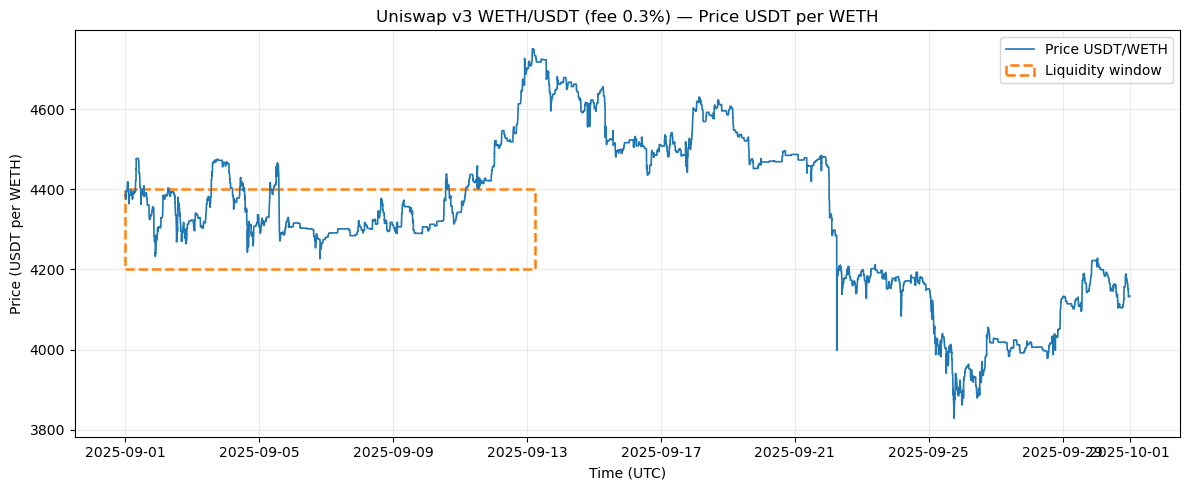

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num

# Price visualization with position window
Q96 = 2 ** 96
swaps_plot = swaps.copy()
swaps_plot['evt_block_time'] = pd.to_datetime(swaps_plot['evt_block_time'], utc=True)
swaps_plot = swaps_plot.sort_values('evt_block_time').reset_index(drop=True)

# Resolve token symbols/decimals
pool_address = pool_cfg.loc[0, 'pool']
token0_addr = pool_cfg.loc[0, 'token0'].lower()
token1_addr = pool_cfg.loc[0, 'token1'].lower()

tokens_df = tokens.copy()
tokens_df['contract_address'] = tokens_df['contract_address'].str.lower()
addr_to_decimals = dict(zip(tokens_df['contract_address'], tokens_df['decimals']))
addr_to_symbol = dict(zip(tokens_df['contract_address'], tokens_df['symbol']))

decimals0 = int(addr_to_decimals[token0_addr])
decimals1 = int(addr_to_decimals[token1_addr])
symbol0 = addr_to_symbol[token0_addr]
symbol1 = addr_to_symbol[token1_addr]

sqrt_x96 = swaps_plot['sqrtPriceX96'].astype('float64')
price_1_per_0 = (sqrt_x96 / Q96) ** 2 * (10 ** (decimals0 - decimals1))
ts = swaps_plot['evt_block_time']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts, price_1_per_0, color='#1f77b4', linewidth=1.2, label=f'Price {symbol1}/{symbol0}')

x0 = date2num(pd.to_datetime(T_START_ISO, utc=True))
x1 = date2num(pd.to_datetime(T_END_ISO, utc=True))
w = x1 - x0
rect = Rectangle((x0, PRICE_LOWER), w, (PRICE_UPPER - PRICE_LOWER),
                 fill=False, edgecolor='#ff7f0e', linewidth=1.8, linestyle='--', label='Liquidity window')
ax.add_patch(rect)

ax.set_title(f'Uniswap v3 {symbol0}/{symbol1} (fee 0.3%) — Price {symbol1} per {symbol0}')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel(f'Price ({symbol1} per {symbol0})')
ax.grid(True, alpha=0.25)
ax.legend(loc='best')
plt.tight_layout()
plt.show()
